<a href="https://colab.research.google.com/github/nejukmaster/Do-it-ML/blob/main/5%EC%9E%A5%20%ED%9B%88%EB%A0%A8%20%EC%B5%9C%EC%A0%81%ED%99%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5장 1절 검증세트와 테스트 세트

**검증세트 준비**

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all,x_test,y_train_all,y_test = train_test_split(x, y, stratify=y, test_size = 0.2, random_state = 42)

In [3]:
x_train,x_val,y_train,y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size = 0.2, random_state = 42)
print(len(x_train),len(x_val))

364 91


['mean perimeter' 'mean area']


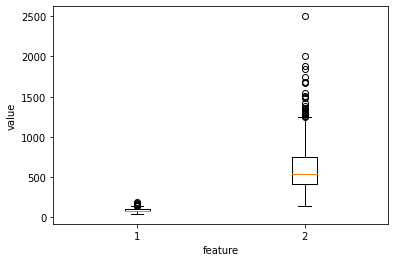

In [4]:
#boxplot 설명:https://velog.io/@youjung/matplotlib%EC%9C%BC%EB%A1%9C-Box-plot-%EA%B7%B8%EB%A6%AC%EA%B8%B0
print(cancer.feature_names[[2,3]])
plt.boxplot(x_train[:, 2:4])
plt.xlabel("feature")
plt.ylabel("value")
plt.show()
#보는 바와같이 데이터셋의 두 특성의 범위(Scale)이 크게 차이남을 볼 수 있다.

In [5]:
#가중치를 기록하는 로지스틱 단일층 정의
class SingleLayer:
    
    def __init__(self):
        self.w = None
        self.w_history = []
        self.b = None
        self.losses = []
        self.learning_rate = 0.2

    def forpass(self, x):
        z = np.sum(x * self.w) + self.b  # 직선 방정식을 계산합니다
        return z

    def backprop(self, x, err):
        w_grad = x * err    # 가중치에 대한 그래디언트를 계산합니다
        b_grad = 1 * err    # 절편에 대한 그래디언트를 계산합니다
        return w_grad, b_grad

    def activation(self, z):
        z = np.clip(z, -100, None) # 안전한 np.exp() 계산을 위해
        a = 1 / (1 + np.exp(-z))  # 시그모이드 계산
        return a
        
    def fit(self, x, y, epochs=100):
        self.w = np.ones(x.shape[1])               # 가중치를 초기화합니다.
        self.b = 0                                 # 절편을 초기화합니다.
        for i in range(epochs):                    # epochs만큼 반복합니다
            loss = 0
            # 인덱스를 섞습니다
            indexes = np.random.permutation(np.arange(len(x)))
            for i in indexes:                      # 모든 샘플에 대해 반복합니다
                z = self.forpass(x[i])             # 정방향 계산
                a = self.activation(z)             # 활성화 함수 적용
                err = -(y[i] - a)                  # 오차 계산
                w_grad, b_grad = self.backprop(x[i], err) # 역방향 계산
                self.w -= w_grad                   # 가중치 업데이트
                
                #****주의점****
                #list에 변수를 그냥 append하게 되면
                #그 변수의 값이 아닌 주소가
                #list에 append되므로
                #기록이 필요할 경우 .copy()메소드로
                #값만 append한다.
                self.w_history.append(self.w.copy())#가중치 기록
                self.b -= b_grad                   # 절편 업데이트
                # 안전한 로그 계산을 위해 클리핑한 후 손실을 누적합니다
                a = np.clip(a, 1e-10, 1-1e-10)
                loss += -(y[i]*np.log(a)+(1-y[i])*np.log(1-a))
            # 에포크마다 평균 손실을 저장합니다
            self.losses.append(loss/len(y))
    
    def predict(self, x):
        z = [self.forpass(x_i) for x_i in x]     # 정방향 계산
        return np.array(z) > 0                   # 스텝 함수 적용
    
    def score(self, x, y):
        return np.mean(self.predict(x) == y)

In [6]:
layer1 = SingleLayer()
layer1.fit(x_train, y_train,epochs=200)

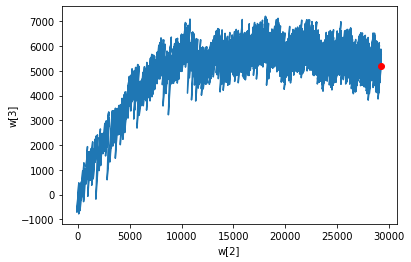

In [7]:
w2 = []
w3 = []
for w in layer1.w_history:
  w2.append(w[2])
  w3.append(w[3])
plt.plot(w2,w3)
#리스트의 인덱스를 -1로 하면 리스트 제일 뒤의 값을 반환한다.
#"ro"는 "r":빨간색의 "o":원형 마커를 사용하겠다는 의미이다
plt.plot(w2[-1],w3[-1],'ro')
plt.xlabel("w[2]")
plt.ylabel("w[3]")
plt.show()
#아래와 같이 Scale을 조정하지 않는다면 가중치 증감폭이 아주 크게 나타남을 볼 수 있다.

**표준화**

In [8]:
#mean:평균
train_mean = np.mean(x_train,axis=0)
#std:표준편차
train_std = np.std(x_train, axis=0)
#axis는 평균 또는 표준편차를 구할 기준축이다.
x_train_scaled = (x_train - train_mean)/train_std #표준화: (x - 평균)/표준편차

In [9]:
#axis 이해하기
n = np.array([[1,2,3,4,5],[1,3,4,2,8],[2,7,3,3,4],[2,5,5,4,3]])
#세로(같은 특성내)
print(np.mean(n,axis=0))
#가로(같은 샘플내)
print(np.mean(n,axis=1))

[1.5  4.25 3.75 3.25 5.  ]
[3.  3.6 3.8 3.8]


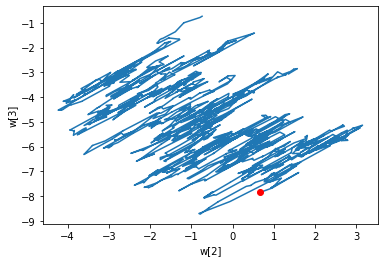

In [10]:
layer2 = SingleLayer()
layer2.fit(x_train_scaled,y_train)
w2 = []
w3 = []
for w in layer2.w_history:
  w2.append(w[2])
  w3.append(w[3])
plt.plot(w2,w3)
plt.plot(w2[-1],w3[-1],'ro')
plt.xlabel("w[2]")
plt.ylabel("w[3]")
plt.show()
#가중치 증감폭이 확연히 준 것을 확인할 수 있다.

**검증 세트도 전처리**

In [11]:
#검증세트를 표준화로 전처리
val_mean = np.mean(x_val,axis=0)
val_std = np.std(x_val, axis=0)
x_val_scaled = (x_val - val_mean)/val_std

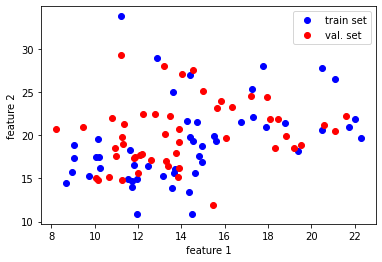

In [12]:
plt.plot(x_train[:50, 0], x_train[:50, 1], 'bo')
plt.plot(x_val[:50, 0], x_val[:50, 1], 'ro')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(['train set', 'val. set'])
plt.show()
#전처리전 검증세트 산점도

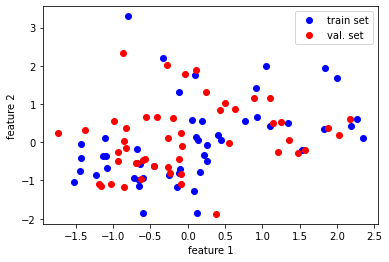

In [13]:
plt.plot(x_train_scaled[:50, 0], x_train_scaled[:50, 1], 'bo')
plt.plot(x_val_scaled[:50, 0], x_val_scaled[:50, 1], 'ro')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(['train set', 'val. set'])
plt.show()
#전처리 후 산점도
#0.0~0.5사이의 값들이 조금더 벌어진 것을 볼 수있다.
#이대로 검증하게될경우 정확한 성능 평가가 어렵다

위와 같은 현상이 나타난 이유는 훈련세트와 검증세트는 다른 분포를 갖기 때문에 각자의 분포에 맞게 표준화가 되어 저런 오차가 발생하는것!

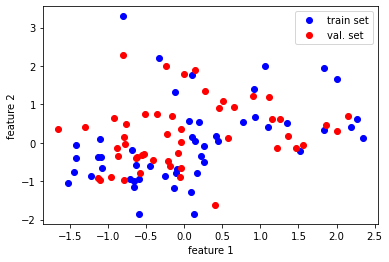

In [14]:
#위 같은 현상을 방지하기위해 검증세트를 표준화할때는 훈련 세트의 평균과 표준편차를 사용한다.
x_val_scaled = (x_val - train_mean)/train_std
plt.plot(x_train_scaled[:50, 0], x_train_scaled[:50, 1], 'bo')
plt.plot(x_val_scaled[:50, 0], x_val_scaled[:50, 1], 'ro')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(['train set', 'val. set'])
plt.show()
#산점도가 전처리전 산점도와 같음을 확인할 수 있다.

In [15]:
layer2.score(x_val_scaled, y_val)
#정확도 상승

0.945054945054945

# 5장 2절 과대적합과 과소적합

In [16]:
#가중치를 기록하는 로지스틱 단일층 정의
class SingleLayer:
    
    def __init__(self):
        self.w = None
        self.w_history = []
        self.b = None
        self.losses = []
        self.val_losses = []
        self.learning_rate = 0.2

    def forpass(self, x):
        z = np.sum(x * self.w) + self.b  # 직선 방정식을 계산합니다
        return z

    def backprop(self, x, err):
        w_grad = x * err    # 가중치에 대한 그래디언트를 계산합니다
        b_grad = 1 * err    # 절편에 대한 그래디언트를 계산합니다
        return w_grad, b_grad

    def activation(self, z):
        z = np.clip(z, -100, None) # 안전한 np.exp() 계산을 위해
        a = 1 / (1 + np.exp(-z))  # 시그모이드 계산
        return a
        
    def fit(self, x, y, _x, _y,  epochs=100):
        self.w = np.ones(x.shape[1])               # 가중치를 초기화합니다.
        self.b = 0                                 # 절편을 초기화합니다.
        for i in range(epochs):                    # epochs만큼 반복합니다
            loss = 0
            # 인덱스를 섞습니다
            indexes = np.random.permutation(np.arange(len(x)))  
            for i in indexes:                      # 모든 샘플에 대해 반복합니다
                z = self.forpass(x[i])             # 정방향 계산
                a = self.activation(z)             # 활성화 함수 적용
                err = -(y[i] - a)                  # 오차 계산
                w_grad, b_grad = self.backprop(x[i], err) # 역방향 계산
                self.w -= self.learning_rate*w_grad                   # 가중치 업데이트
                
                #****주의점****
                #list에 변수를 그냥 append하게 되면
                #그 변수의 값이 아닌 주소가
                #list에 append되므로
                #기록이 필요할 경우 .copy()메소드로
                #값만 append한다.
                self.w_history.append(self.w.copy())#가중치 기록
                self.b -= self.learning_rate*b_grad                   # 절편 업데이트
                # 안전한 로그 계산을 위해 클리핑한 후 손실을 누적합니다
                a = np.clip(a, 1e-10, 1-1e-10)
                loss += -(y[i]*np.log(a)+(1-y[i])*np.log(1-a))
            # 에포크마다 평균 손실을 저장합니다
            self.losses.append(loss/len(y))
            val_loss = 0;
            indexes = np.random.permutation(np.arange(len(_x)))
            for i in indexes:
              z = self.forpass(_x[i])
              a = self.activation(z)
              err = -(_y[i] - a)
              a = np.clip(a, 1e-10, 1-1e-10)
              val_loss += -(_y[i]*np.log(a)+(1-_y[i])*np.log(1-a))
            self.val_losses.append(val_loss/len(_y))
    
    def predict(self, x):
        z = [self.forpass(x_i) for x_i in x]     # 정방향 계산
        return np.array(z) > 0                   # 스텝 함수 적용
    
    def score(self, x, y):
        return np.mean(self.predict(x) == y)

In [17]:
layer4 = SingleLayer()
layer4.fit(x_train_scaled, y_train, x_val_scaled, y_val)

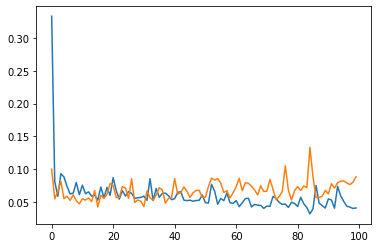

In [18]:
plt.plot(layer4.losses)
plt.plot(layer4.val_losses)
plt.show()
#에포크가 진행될수록 검증세트의 손실이 올라, 모델이 과대적합되었음을 알 수 있다.

# 5장 3절 가중치 규제

그래프의 기울기, 즉 모델의 가중치가 작을수록 일반화가 잘된다. ▶ 가중치를 적절히 규제하여 모델의 성능을 높인다.

In [19]:
from google.colab import drive
from IPython.display import Image
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


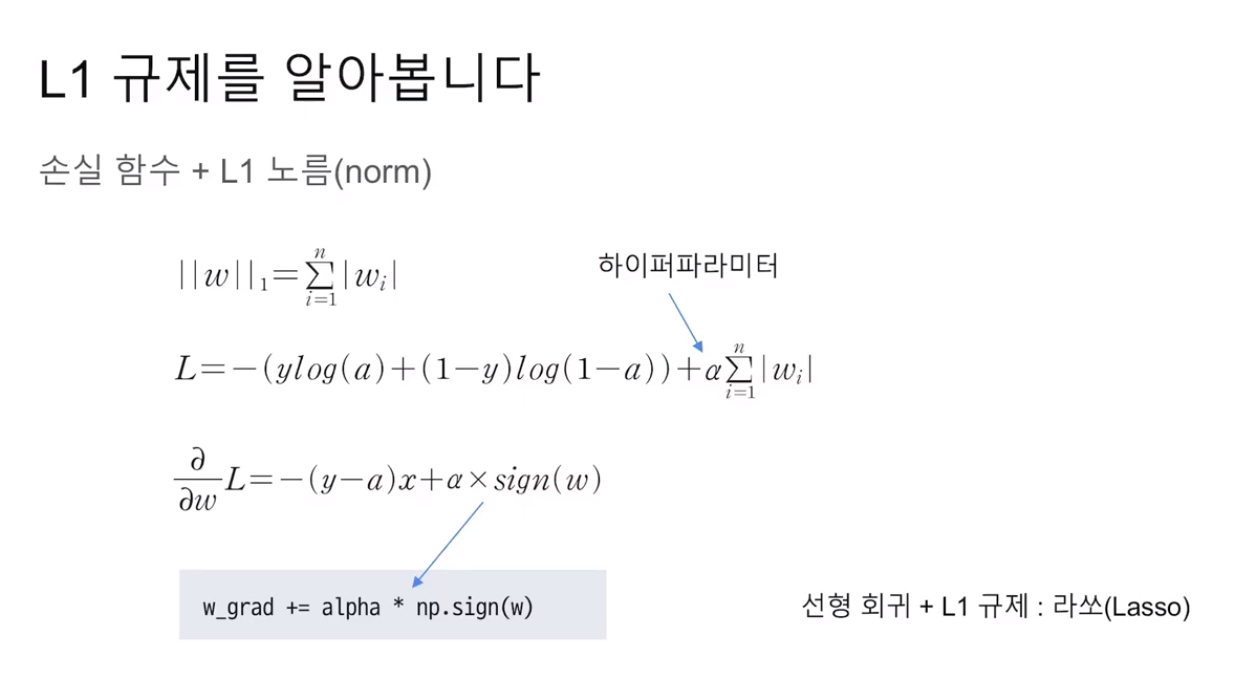

In [20]:
Image('/gdrive/My Drive/Colab Notebooks/Images/L1규제.png')
#밑에서 하이퍼 파라미터는 모델에서 인자로 받아 사용자가 직접 설정하는 값을 의미한다.